In [1]:
# LSTM 有两层 LSTM 的结构

In [2]:
# GPU -- 准备来做一个GPU版本的RNN
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt

# 设置 GPU 优先
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 加载数据
dataset = pd.read_csv("601229.csv", index_col=0)
dataset = dataset.drop(['date','prediction'], axis=1)
# print(dataset.columns)
# print(dataset.tail())
dataset['future'] = dataset['future']
print(dataset.shape)
# print(dataset.tail())

# 将需要预测的数据"future"缩放在[-1,1]之间
# scaler = MinMaxScaler(feature_range=(-1, 1))
# y_scaled = scaler.fit_transform(np.array(dataset['future']).reshape(-1,1))
# dataset['future'] = y_scaled
# y_rev = scaler.inverse_transform(np.array(dataset['future']).reshape(-1,1))
# print(y_rev)

# 这样写更快.（如果第0列就是 future的话）
# dataset['future'] = scaler.fit_transform(dataset)[:,0]

(250, 123)


In [3]:
# 方法2，将数据按照BATCH_SIZE的窗口进行滑动，每个窗口数据做一组

# # 数据转成sequence的格式，这里定义每个seq的长度
SEQ_LENGTH = 42
BATCH_SIZE = 1                                                    # 注意：BATCH_SIZE是要能够整除seq_count的

# 把数据切换成 BATCH_SIZE 的一个个batch
rolling_data = pd.DataFrame()
for i in dataset.rolling(SEQ_LENGTH):
    if i.shape[0] == SEQ_LENGTH:
        rolling_data = rolling_data.append(i)

rolling_data = rolling_data.values.reshape(-1, SEQ_LENGTH, dataset.shape[1])                 # 数据一共是 seq_count x seq_len x (in_dim+1)

print("rolling_data shape: {}".format(rolling_data.shape))
print("seq count: {}".format(rolling_data.shape[0]))                                       # 所以一共有 seq_count 列数据，每一行的数据是123维 （包括y）
print("seq length: {}".format(SEQ_LENGTH))


total_batch_count = int(rolling_data.shape[0]/BATCH_SIZE)                                   # 把数据规划成 batch_count 个 batch

print("total batch count: {}".format(total_batch_count))
print("batch size: {}".format(BATCH_SIZE))

rolling_data = rolling_data.reshape(total_batch_count, BATCH_SIZE, SEQ_LENGTH, dataset.shape[1])  # 把数据转成 total_batch_count x BATCH_SIZE x seq_len x in_dim 格式
rolling_data = torch.tensor(rolling_data)
print("rolling_data: {}".format(rolling_data.shape))


train_batch_count = total_batch_count - 1
test_batch_count = total_batch_count - train_batch_count

train = rolling_data[:train_batch_count, :, :, :]
test  = rolling_data[train_batch_count:, :, :, :]

train_x, train_y = train[:,:,:,1:], train[:,:,:,0:1]
test_x,  test_y  = test[:,:,:, 1:],  test[:,:,:,0:1]

train_x = train_x.to(device)
train_y = train_y.to(device)
test_x = test_x.to(device)
test_y = test_y.to(device)

print("train_x: {}".format(train_x.shape))
print("train_y: {}".format(train_y.shape))
print("test_x:  {}".format(test_x.shape))
print("test_y:  {}".format(test_y.shape))
print("train_batch_count: {}".format(train_batch_count))
print("test_batch_count:  {}".format(test_batch_count))

rolling_data shape: (209, 42, 123)
seq count: 209
seq length: 42
total batch count: 209
batch size: 1
rolling_data: torch.Size([209, 1, 42, 123])
train_x: torch.Size([208, 1, 42, 122])
train_y: torch.Size([208, 1, 42, 1])
test_x:  torch.Size([1, 1, 42, 122])
test_y:  torch.Size([1, 1, 42, 1])
train_batch_count: 208
test_batch_count:  1


In [4]:
# 开始定义 LSTM 模型
TIME_STEP = SEQ_LENGTH                                        # 一般这个单独设定，这里为了简单，还是直接就等于seq_len的方便。其实也就是等于最长的那个sequence length
INPUT_SIZE = dataset.shape[1]-1
HIDDEN_SIZE = 256
NUM_LAYERS = 1

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, num_layers, output_size, dropout=0.5):
        super().__init__()
        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm1 = nn.LSTM(input_size=hidden_layer_size, hidden_size=int(hidden_layer_size/2), num_layers=num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=int(hidden_layer_size/2), hidden_size=hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(hidden_layer_size, output_size)

        self.h1 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.c1 = torch.zeros(NUM_LAYERS, BATCH_SIZE, int(hidden_layer_size/2)).double().to(device)
        self.h2 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        self.c2 = torch.zeros(NUM_LAYERS, BATCH_SIZE, hidden_layer_size).double().to(device)
        
        self.init_weights3()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)

    def init_weights2(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                nn.init.kaiming_normal_(param)    
    
    def init_weights3(self):
        for name, param in self.lstm1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
        for name, param in self.lstm2.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                nn.init.orthogonal_(param)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param)
                
    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.dropout(x)
        
        # 去掉以后更拟合，但没有验证泛化能力如何
        # x = self.relu(x)
        
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch        
        # LSTM layer
        # lstm_out, (h_n, c_n) = self.lstm(x, (self.h0.detach(), self.c0.detach()))
        
        lstm1_out, (h1_n, c1_n) = self.lstm1(x, (self.h1, self.c1))
        lstm_out, (h_n, c_n) = self.lstm2(lstm1_out, (self.h2, self.c2))

        lstm_out = self.dropout(lstm_out)
        
        predictions = self.linear_2(lstm_out)
        return predictions


In [10]:
np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)
torch.backends.cudnn.deterministic = True


# 初始化 LSTM 模型
model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, output_size=1)
model = model.to(device)
LR = 1e-6
loss_func = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-6)


# 训练 LSTM 模型; 
epoches = 500
epoch_loss = 0
epoch_loss_list = []

for epoch in range(epoches):
    for step in range(train_batch_count):
        # print(train_x[i])
        # print(train_x[i].shape)
        model = model.double()
        pred = model(train_x[step])
        loss = loss_func(pred, train_y[step])
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=20, norm_type=2)
        optimizer.step()
        
        epoch_loss += loss.data
        
    # print(loss.item())
    
    if loss.item() < 1e-4:
        print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch+1, epoches, loss.item()))
        print("The loss value is reached")
        break
    elif (epoch+1)%10 == 0:
        print("{} of {} epoch loss: {:.6f}".format(epoch, epoches, epoch_loss.item()))
        epoch_loss_list.append(epoch_loss.cpu())
        # print("learning rate: {}".format(optimizer.state_dict()['param_groups'][0]['lr']))
        # for p in optimizer.param_groups:
            # p['lr'] *= 0.95
    
    epoch_loss = 0

plt.plot(epoch_loss_list)
plt.show()    

9 of 500 epoch loss: 1.073763
19 of 500 epoch loss: 1.023234
29 of 500 epoch loss: 0.996967
39 of 500 epoch loss: 0.966413
49 of 500 epoch loss: 0.950495
59 of 500 epoch loss: 0.942133
69 of 500 epoch loss: 0.933712
79 of 500 epoch loss: 0.920358
89 of 500 epoch loss: 0.913053
99 of 500 epoch loss: 0.900887
109 of 500 epoch loss: 0.900037
119 of 500 epoch loss: 0.881613
129 of 500 epoch loss: 0.877435
139 of 500 epoch loss: 0.869086
149 of 500 epoch loss: 0.857805
159 of 500 epoch loss: 0.853985
169 of 500 epoch loss: 0.842811
179 of 500 epoch loss: 0.852494
189 of 500 epoch loss: 0.837574
199 of 500 epoch loss: 0.834699
209 of 500 epoch loss: 0.829967
219 of 500 epoch loss: 0.831932
229 of 500 epoch loss: 0.824279
239 of 500 epoch loss: 0.819925
249 of 500 epoch loss: 0.821365
259 of 500 epoch loss: 0.802819
269 of 500 epoch loss: 0.808833
279 of 500 epoch loss: 0.799104
289 of 500 epoch loss: 0.802894
299 of 500 epoch loss: 0.793644
309 of 500 epoch loss: 0.784280
319 of 500 epoch lo

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

Prediction: 0.00
loss : 0.002594


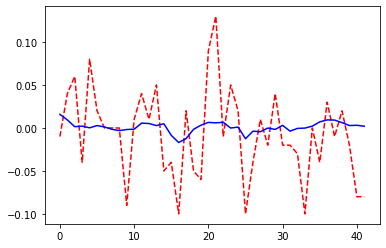

In [6]:
# GPU -- 用模型来做测试数据的误差

for step in range(test_batch_count):
    pred = model(test_x[step])

    loss = loss_func(pred, test_y[step].to(device))

    print("Prediction: {:.2f}".format(float(pred[-1][-1].data)))
    
    print("loss : {:.6f}".format(float(loss.data)))

    # print(test_y[step][-1].flatten().shape)
    # print(pred[-1].flatten().shape)
    
    # actual_line = test_y[step][-1].cpu().detach().flatten().numpy()
    # pred_line   = pred[-1].cpu().detach().flatten().numpy()
    
    actual_line = test_y[step].cpu().detach().flatten().numpy()
    pred_line   = pred.cpu().detach().flatten().numpy()
    
    plt.plot(actual_line, 'r--')
    plt.plot(pred_line, 'b-')
    plt.show()
    
# actual_line = np.array(test_y[-1]).flatten().tolist()
# pred_line = pred.data.numpy().flatten().tolist()

# actual_line = np.array(test_y[0][-1]).flatten().tolist()
# pred_line = pred[-1].data.numpy().flatten().tolist()


